# Relating variability in NL association to changes in transcription

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/3_Preimplantation.Relating_NLassociation_and_transcription.part2a.relating_variability_in_NL_and_transcription/'


In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

# BINSIZE = 100000
MINMAP_PER_KB = 1
# MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# CELseq file names
CELSEQCOUNTS = '../../combining_all_data/data/celseq_counts/FR230814.CELseq.sample_counts.{genotype}.celseq_pass.tsv.gz'

# Gene information
GENESFN = HOME + 'references/mouse/mm10/genomic_element_info/FR200630.BioMart.mm10.all_genes.top_transcripts.txt.gz'
PARKFN = HOME + 'projects/preimplantation/DRA001066/data/tables/FR200923.Park_clusters_by_Ensembl_ID.tsv'

In [5]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

## Loading metadata

In [6]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno.cellcount == 1]
anno = anno[anno.treatment == 'no_treatment']
anno = anno[anno['stage'].isin(stage_order)]
anno = anno.set_index('damid_name')

In [7]:
print('DamID PASS: ', anno.DamID_PASS.sum())
print('CELseq PASS: ', anno.CELseq_PASS.sum())
print('Both PASS: ', (anno.DamID_PASS & anno.CELseq_PASS).sum())

DamID PASS:  816
CELseq PASS:  1079
Both PASS:  541


In [8]:
anno = anno[anno.DamID_PASS & anno.CELseq_PASS]

In [9]:
anno.groupby(['stage', 'genotype', 'treatment']).size()

stage   genotype                treatment   
2cell   CBAB6F1_x_CAST/EiJ      no_treatment     24
        homozygous              no_treatment     69
8cell   CBAB6F1_x_CAST/EiJ      no_treatment     21
        homozygous              no_treatment    129
mESC    129S1/SvImJ_x_CAST/EiJ  no_treatment    196
zygote  CBAB6F1_x_CAST/EiJ      no_treatment     14
        homozygous              no_treatment     88
dtype: int64

In [10]:
# remove F1xCAST samples, because there are so few of them
anno = anno[~anno.genotype.isin(['CBAB6F1_x_CAST/EiJ'])]

## Loading gene information

Loading gene information, most notably the location of the most reliable transcript:

In [11]:
genes = pd.read_csv(GENESFN, sep='\t')
genes = genes.rename(columns={
    'Chromosome/scaffold name': 'chrom',
    'Gene start (bp)': 'gene_start',
    'Gene end (bp)': 'gene_end',
    'Strand': 'strand',
    'Transcript start (bp)': 'transcript_start',
    'Transcript end (bp)': 'transcript_end',
    'Transcription start site (TSS)': 'tss',
    'Gene stable ID version': 'gene_id',
    'Transcript stable ID version': 'tid',
    'Gene name': 'gene_name',
    'Gene type': 'gene_type',
    'Transcript length (including UTRs and CDS)': 'transcript_length'
})
genes = genes.drop(columns=['Transcript support level (TSL)', 'GENCODE basic annotation', 'APPRIS annotation'])

genes['gene_id'] = genes.gene_id.apply(func = lambda gene_id: gene_id.split('.')[0])
genes['tid'] = genes.tid.apply(func = lambda tid: tid.split('.')[0])

## Load park gene annotations
park_clusters = pd.read_csv(PARKFN, sep='\t')
park_clusters = park_clusters.rename(columns={'Cluster': 'Park_cluster', 'ensembl_gene_id': 'gene_id'})
park_clusters = park_clusters.drop(columns=['Entrez'])
park_clusters = park_clusters[~park_clusters['gene_id'].isna()]
park_clusters = park_clusters[~park_clusters.duplicated()]
dup_gids = park_clusters.loc[park_clusters.gene_id.duplicated(), 'gene_id'].unique()
park_clusters.loc[park_clusters.gene_id.isin(dup_gids), 'Park_cluster'] = 'no_cluster'
park_clusters = park_clusters[~park_clusters.duplicated()]

## Merge info
genes = genes.merge(park_clusters, how='left', on='gene_id')
genes['Park_cluster'] = genes['Park_cluster'].fillna('no_cluster')
genes['is_maternal'] = genes['Park_cluster'].str.contains('Maternal')
genes = genes.set_index('gene_id')

## Select only genes on valid chromosomes
genes = genes[genes.chrom.isin(chrom_order)]

assert genes.index.duplicated().sum() == 0

## Loading CELseq data

In [12]:
counts_ls = list()

for genotype, _ in anno.groupby('genotype'):
    gt_name = genotype if genotype == 'homozygous' else genotype.replace('/','') + '.combined'
    fn = CELSEQCOUNTS.format(genotype=gt_name)
    assert len(glob(fn)) == 1, fn
    
    print(genotype)
    
    counts = pd.read_csv(fn, sep='\t')
    counts_ls.append(counts)
    
if len(counts_ls) > 1:
    A = counts_ls[0]['gene_id']
    for i in range(1,len(counts_ls)):
        assert all(counts_ls[i]['gene_id'] == A)
        
        counts_ls[i] = counts_ls[i].iloc[:,2:]
celseq_counts = pd.concat(counts_ls, axis=1)
counts_ls = None
counts = None

# selecting samples also in samplesheet
s = celseq_counts.columns.values[2:]
s = s[np.isin(s, anno.celseq_name.values)]
cols = ['gene_id', 'gene_name'] + list(s)
celseq_counts = celseq_counts[cols]

# rename samples to damid names
s = celseq_counts.columns.values[2:]
tmp = anno.reset_index().set_index('celseq_name').loc[s,'damid_name'].values
cols = ['gene_id', 'gene_name'] + list(tmp)
celseq_counts.columns = cols
celseq_counts = celseq_counts.set_index('gene_id').drop(columns='gene_name')

129S1/SvImJ_x_CAST/EiJ
homozygous


__Make sure gene ids in gene info DF correspond to gene ids in celseq data__

In [13]:
ind = genes.index.isin(celseq_counts.index)
print(ind.mean(), ind.sum())
genes = genes[ind].sort_values(by=['chrom', 'tss'])

ind = celseq_counts.index.isin(genes.index)
print(ind.mean(), ind.sum())
celseq_counts = celseq_counts[ind]

0.9264142764251138 51290
0.9862702869010076 51290


In [14]:
celseq_counts = celseq_counts.loc[genes.index,:]

__Computing depth normalized celseq values__

In [15]:
C = celseq_counts.values
d = C.sum(axis=0)
d = np.reshape(d, (1, len(d)))
C = np.log1p(C / d * 1e4)
celseq_lognorm = pd.DataFrame(C, columns=celseq_counts.columns, index=celseq_counts.index)

__Computing standardized celseq values__

In [16]:
C = celseq_lognorm.values
m = C.mean(axis=1)
s = np.std(C, axis=1)

m = np.reshape(m, (len(m), 1))
s = np.reshape(s, (len(s), 1))

C = (C - m) / s
celseq_zscore = pd.DataFrame(C, columns=celseq_counts.columns, index=celseq_counts.index).fillna(0)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6768/2698523415.py:8: RuntimeWarning: invalid value encountered in true_divide
  C = (C - m) / s


__Generating _in silico_ celseq populations:__

In [17]:
celseq_per_stage = dict()

for name, df in {'counts': celseq_counts, 'lognorm': celseq_lognorm, 'zscore': celseq_zscore}.items():
    
    df = df.copy()
    df = df.T
    
    annotmp = anno.copy()
    df = df.loc[annotmp.index.values,:]
    
    df['stage'] = annotmp.loc[df.index, 'stage'].values
    df['genotype'] = annotmp.loc[df.index, 'genotype'].values
    df['treatment'] = annotmp.loc[df.index, 'treatment'].values
    
    if name == 'counts':
        df = df.groupby(['stage', 'genotype', 'treatment']).sum()
    else:
        df = df.groupby(['stage', 'genotype', 'treatment']).mean()
    
    df = df.reset_index()
    df['condition'] = df.apply(axis=1, func = lambda r: '%s - %s - %s' % (r['stage'], r['genotype'], r['treatment']))
    df = df.drop(columns=['stage', 'genotype', 'treatment']).set_index('condition').T
    
    celseq_per_stage[name] = df

## Loading per gene DamID info

In [18]:
per_gene_damid_lognorm = dict()
per_gene_damid_binary = dict()

In [19]:
for binsize in [10000, 100000, 1000000]:
    print('current binsize: ', binsize)
    
    damid_tss_counts = list()
    damid_tx_counts = list()

    # loop over different files
    for (construct, genotype), _ in anno.groupby(['fusion_construct', 'genotype']):
        gt_name = genotype if genotype == 'homozygous' else genotype.replace('/','') + '.combined'
        fn = COUNTS.format(construct=construct, genotype=gt_name, binsize=binsize)
        assert len(glob(fn)) == 1, fn

        print(construct, genotype)

        # load all damid data
        with h5py.File(fn, 'r') as f:
            samples = np.array([s.decode() for s in f['sample_names'][:]])
            i_samples = np.arange(len(samples))
            all_data = {c: f[c][:] for c in chrom_order}
            
        # select only samples that are in anno
        if genotype == 'homozygous':
            ind = np.isin(samples, anno.index.values) | (samples == 'mappability')
        else:
            ind = np.isin(samples, anno.index.values)
        samples = samples[ind]
        i_samples = i_samples[ind]
        
        df_tss = dict()
        df_tss['damid_name'] = samples
        
        if binsize == 10000:
            df_tx = dict()
            df_tx['damid_name'] = samples
            
        # iterate over all genes and select appropriate damid data
        for gid, row in tqdm(genes.iterrows(), total=len(genes)):
            
            chrom = row['chrom']
            D = all_data[chrom]
            s_ind = int(row['transcript_start'] // binsize)
            e_ind = int(row['transcript_end'] // binsize) + 1
            e_ind = min(e_ind, D.shape[0])
            t_ind = int(row['tss'] // binsize)
            
            if t_ind < D.shape[0]:
                df_tss[gid] = D[t_ind,i_samples]
                
            if (binsize == 10000) and (s_ind < D.shape[0]):
                df_tx[gid] = D[s_ind:e_ind,i_samples].mean(axis=0)

        df_tss = pd.DataFrame(df_tss).set_index('damid_name').T
        damid_tss_counts.append(df_tss)
        
        if binsize == 10000:
            df_tx = pd.DataFrame(df_tx).set_index('damid_name').T
            damid_tx_counts.append(df_tx)
            
        # save total mappability depth
        if genotype == 'homozygous':
            m_total = sum([all_data[c][:,0].sum() for c in chrom_order])

    if binsize == 10000:
        to_save = {'tss_binsize_%d' % binsize: damid_tss_counts, 'tx_binsize_%d' % binsize: damid_tx_counts}
    else:
        to_save = {'tss_binsize_%d' % binsize: damid_tss_counts}
        
    for name, damid_counts in to_save.items():
        
        # combine all data
        outdf = pd.concat(damid_counts, axis=1)

        # depth normalize
        outdf_lognorm = outdf.copy().drop(columns='mappability')
        depths = anno.loc[outdf_lognorm.columns.values, 'unique_damid_counts'].values
        depths = np.reshape(depths, (1, len(depths)))
        outdf_lognorm = np.log1p(outdf_lognorm / depths * 1e4)

        # binarize
        m_norm = np.log1p(outdf['mappability'].values / m_total * 1e4)
        m_norm = np.reshape(m_norm, (len(m_norm),1))
        outdf_binary = outdf_lognorm.copy()
        outdf_binary = ((outdf_binary - m_norm) > 0).astype(int)

        per_gene_damid_lognorm[name] = outdf_lognorm.loc[genes.index,:]
        per_gene_damid_binary[name] = outdf_binary.loc[genes.index,:]
        genes.loc[outdf.index, 'mapab_%s' % name] = outdf['mappability'].values        

current binsize:  10000
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ


  0%|          | 0/51290 [00:00<?, ?it/s]

Dam-Lmnb1 homozygous


  0%|          | 0/51290 [00:00<?, ?it/s]

current binsize:  100000
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ


  0%|          | 0/51290 [00:00<?, ?it/s]

Dam-Lmnb1 homozygous


  0%|          | 0/51290 [00:00<?, ?it/s]

current binsize:  1000000
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ


  0%|          | 0/51290 [00:00<?, ?it/s]

Dam-Lmnb1 homozygous


  0%|          | 0/51290 [00:00<?, ?it/s]

__Add smoothened binary values as used in CF computation__

In [20]:
for binsize in [100000, 1000000]:
    print('current binsize: ', binsize)
    
    damid_tss_counts = list()
    damid_tx_counts = list()

    # loop over different files
    for (construct, genotype), _ in anno.groupby(['fusion_construct', 'genotype']):
        gt_name = genotype if genotype == 'homozygous' else genotype.replace('/','') + '.combined'
        fn = BINARY.format(construct=construct, genotype=gt_name, binsize=binsize)
        assert len(glob(fn)) == 1, fn

        print(construct, genotype)

        # load all damid data
        with h5py.File(fn, 'r') as f:
            samples = np.array([s.decode() for s in f['sample_names'][:]])
            i_samples = np.arange(len(samples))
            all_data = {c: f[c][:].astype(int) for c in chrom_order}
            
        # select only samples that are in anno
        ind = np.isin(samples, anno.index.values)
        samples = samples[ind]
        i_samples = i_samples[ind]
        
        df_tss = dict()
        df_tss['damid_name'] = samples
            
        # iterate over all genes and select appropriate damid data
        for gid, row in tqdm(genes.iterrows(), total=len(genes)):
            
            chrom = row['chrom']
            D = all_data[chrom]
            t_ind = int(row['tss'] // binsize)
            
            if t_ind < D.shape[0]:
                df_tss[gid] = D[t_ind,i_samples]

        df_tss = pd.DataFrame(df_tss).set_index('damid_name').T
        damid_tss_counts.append(df_tss)

    outdf = pd.concat(damid_tss_counts, axis=1)
    per_gene_damid_binary['tss_smooth_binsize_%d' % binsize] = outdf.loc[genes.index,:]

current binsize:  100000
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ


  0%|          | 0/51290 [00:00<?, ?it/s]

Dam-Lmnb1 homozygous


  0%|          | 0/51290 [00:00<?, ?it/s]

current binsize:  1000000
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ


  0%|          | 0/51290 [00:00<?, ?it/s]

Dam-Lmnb1 homozygous


  0%|          | 0/51290 [00:00<?, ?it/s]

# 1. Test: Correlation between gene Lmnb1 contact values and expression

In [21]:
from collections import defaultdict

In [22]:
results = dict()

for damidset in per_gene_damid_lognorm.keys():
    results[damidset] = dict()
    print(damidset)

    for info, df in anno.groupby(['stage', 'genotype']):

        samples = df.index.values
        binsize = int(damidset.split('_')[-1])

        # select genes that are mappable and expressed in at least 5 cells
        ind0 = genes['mapab_%s' % damidset] >= (MINMAP_PER_KB*binsize/1000) # select on mappability
        ind1 = ~genes.is_maternal
        gid = genes[ind0 & ind1].index.values
        n_cells_expr = (celseq_counts.loc[gid, samples].values > 0).sum(axis=1)
        gid = gid[n_cells_expr > 5]

        corr_vals = list()

        for g in tqdm(gid):

            A = celseq_lognorm.loc[g, samples].values
            B = per_gene_damid_lognorm[damidset].loc[g, samples].values

            r, p = stats.pearsonr(A, B)

            corr_vals.append(r)

        corr_vals = np.array(corr_vals)

        results[damidset]['%s:%s' % info] = corr_vals

tss_binsize_10000


  0%|          | 0/9902 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


  0%|          | 0/7683 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

  0%|          | 0/10539 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

  0%|          | 0/10287 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

tx_binsize_10000


  0%|          | 0/9906 [00:00<?, ?it/s]

  0%|          | 0/7687 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


  0%|          | 0/10549 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

  0%|          | 0/10293 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/f.rang/.venvs/preimplanta

tss_binsize_100000


  0%|          | 0/9924 [00:00<?, ?it/s]

  0%|          | 0/7698 [00:00<?, ?it/s]

  0%|          | 0/10562 [00:00<?, ?it/s]

  0%|          | 0/10306 [00:00<?, ?it/s]

tss_binsize_1000000


  0%|          | 0/9933 [00:00<?, ?it/s]

  0%|          | 0/7707 [00:00<?, ?it/s]

  0%|          | 0/10579 [00:00<?, ?it/s]

  0%|          | 0/10318 [00:00<?, ?it/s]

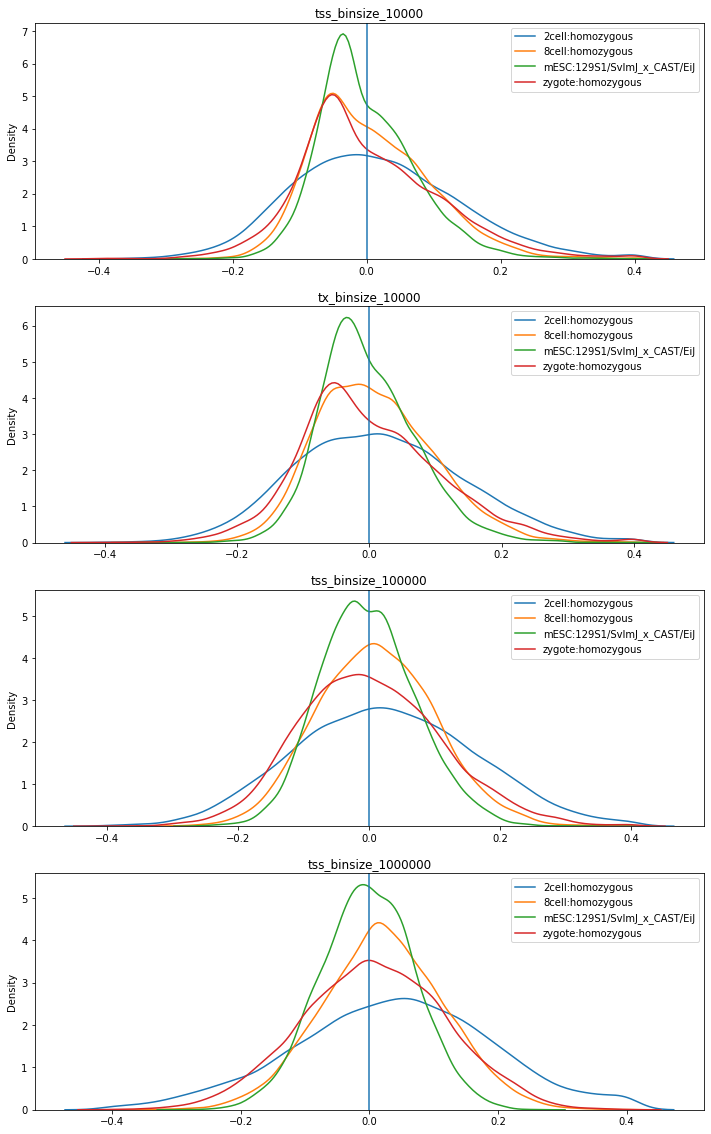

In [23]:
nrow = len(results.keys())

fig, axes = plt.subplots(nrow, 1, figsize=(12,5*nrow))

for i, name in enumerate(results.keys()):
    ax = axes[i]
    ax.set_title(name)
    
    for condition in results[name]:
        sns.kdeplot(results[name][condition].clip(-.4,.4), label=condition, ax=ax)
    ax.axvline(0)
    ax.legend()

# 2. Expression of gene with versus without NL contact

## 2.1 Compute expression values

In [24]:
expr_logfc_contact = dict()

for info, annodf in anno.groupby(['stage', 'genotype', 'treatment']):
    expr_logfc_contact[info] = dict()
    samples = annodf.index.values
    
    for damidset in per_gene_damid_binary.keys():
        binsize = int(damidset.split('_')[-1])
        expr_logfc_contact[info][damidset] = dict()
        
        # select valid genes for this condition
        m_name = ('mapab_%s' % damidset).replace('_smooth', '')
        ind0 = genes[m_name] >= (MINMAP_PER_KB*binsize/1000) # gene region must be mappable
        
        n_cells_expr = (celseq_counts.loc[genes.index, samples].values > 0).sum(axis=1)
        ind1 = n_cells_expr > 5 # gene must be expressed in at least 5 cells
        
        D = per_gene_damid_binary[damidset].loc[genes.index,samples]
        ind2 = (D.sum(axis=1) > 5) | ((~D).sum(axis=1) > 5) # gene must be off and on the lamina in at least 5 cells
        
        gid = genes[ind0&ind1&ind2].index.values
        
        print(info, damidset, len(gid))
        
        # initiate result lists
        
        insilico_logfc = list()
        
        M_contact = per_gene_damid_binary[damidset].loc[gid,samples].values.astype(int).astype(bool)
        M_expr_lognorm = celseq_lognorm.loc[gid,samples].values
        M_expr_counts = celseq_counts.loc[gid,samples].values
        
        # compute average single-cell expression in contact and free states
        avg_logfc = dict()
        avg_logfc['gene_id'] = gid
        avg_logfc['expr'] = np.mean(M_expr_lognorm, axis=1)
        avg_logfc['expr_contact'] = np.mean(M_expr_lognorm, axis=1, where=M_contact)
        avg_logfc['expr_free'] = np.mean(M_expr_lognorm, axis=1, where=(~M_contact))
        avg_logfc['CF'] = M_contact.mean(axis=1)
        avg_logfc['n_cells_expr'] = (M_expr_counts > 0).sum(axis=1)
        avg_logfc['frac_cells_expr'] = (M_expr_counts > 0).mean(axis=1)
        
        expr_logfc_contact[info][damidset]['avg'] = pd.DataFrame(avg_logfc).set_index('gene_id')
        
        # compute insilico single-cell expression in contact and free states
        insilico_logfc = dict()
        t_expr = np.sum(M_expr_counts, axis=1)
        t_expr_contact = np.sum(M_expr_counts, axis=1, where=M_contact)
        t_expr_free = np.sum(M_expr_counts, axis=1, where=(~M_contact))
        
        d = M_expr_counts.sum().sum()
        M_d = M_expr_counts.sum(axis=0)
        M_d = np.reshape(np.repeat(M_expr_counts.sum(axis=0), M_expr_counts.shape[0]), M_expr_counts.shape, order='F')
        d_contact = np.sum(M_d, axis=1, where=M_contact)
        d_free = np.sum(M_d, axis=1, where=(~M_contact))
        
        insilico_logfc['gene_id'] = gid
        insilico_logfc['expr'] = np.log( t_expr / d * 1e6 + 10)
        insilico_logfc['expr_contact'] = np.log( t_expr_contact / d_contact * 1e6 + 10)
        insilico_logfc['expr_free'] = np.log( t_expr_free / d_free * 1e6 + 10)
        insilico_logfc['CF'] = M_contact.mean(axis=1)
        insilico_logfc['n_cells_expr'] = (M_expr_counts > 0).sum(axis=1)
        insilico_logfc['frac_cells_expr'] = (M_expr_counts > 0).mean(axis=1)
        
        expr_logfc_contact[info][damidset]['insilico'] = pd.DataFrame(insilico_logfc).set_index('gene_id')

('2cell', 'homozygous', 'no_treatment') tss_binsize_10000 12895
('2cell', 'homozygous', 'no_treatment') tx_binsize_10000 12527


/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6768/573042344.py:60: RuntimeWarning: invalid value encountered in true_divide
  insilico_logfc['expr_free'] = np.log( t_expr_free / d_free * 1e6 + 10)


('2cell', 'homozygous', 'no_treatment') tss_binsize_100000 11684


/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6768/573042344.py:60: RuntimeWarning: invalid value encountered in true_divide
  insilico_logfc['expr_free'] = np.log( t_expr_free / d_free * 1e6 + 10)


('2cell', 'homozygous', 'no_treatment') tss_binsize_1000000 8562
('2cell', 'homozygous', 'no_treatment') tss_smooth_binsize_100000 9143
('2cell', 'homozygous', 'no_treatment') tss_smooth_binsize_1000000 8562
('8cell', 'homozygous', 'no_treatment') tss_binsize_10000 8904
('8cell', 'homozygous', 'no_treatment') tx_binsize_10000 9839
('8cell', 'homozygous', 'no_treatment') tss_binsize_100000 10094
('8cell', 'homozygous', 'no_treatment') tss_binsize_1000000 7048
('8cell', 'homozygous', 'no_treatment') tss_smooth_binsize_100000 8879
('8cell', 'homozygous', 'no_treatment') tss_smooth_binsize_1000000 7048
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') tss_binsize_10000 12413
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') tx_binsize_10000 13486
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') tss_binsize_100000 13824
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') tss_binsize_1000000 5843


/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6768/573042344.py:60: RuntimeWarning: invalid value encountered in true_divide
  insilico_logfc['expr_free'] = np.log( t_expr_free / d_free * 1e6 + 10)


('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') tss_smooth_binsize_100000 9122


/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6768/573042344.py:60: RuntimeWarning: invalid value encountered in true_divide
  insilico_logfc['expr_free'] = np.log( t_expr_free / d_free * 1e6 + 10)


('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') tss_smooth_binsize_1000000 6656


/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6768/573042344.py:60: RuntimeWarning: invalid value encountered in true_divide
  insilico_logfc['expr_free'] = np.log( t_expr_free / d_free * 1e6 + 10)


('zygote', 'homozygous', 'no_treatment') tss_binsize_10000 5291
('zygote', 'homozygous', 'no_treatment') tx_binsize_10000 11148
('zygote', 'homozygous', 'no_treatment') tss_binsize_100000 13849
('zygote', 'homozygous', 'no_treatment') tss_binsize_1000000 7564
('zygote', 'homozygous', 'no_treatment') tss_smooth_binsize_100000 9415
('zygote', 'homozygous', 'no_treatment') tss_smooth_binsize_1000000 7564


## 2.2 Plot expression of contact vs free using different gene regions and metrics

In [25]:
def compute_trendline(X, Y, nsteps=50):
    x = np.linspace(X.min(), X.max(), nsteps)
    stepwidth = x[1] - x[0]
    
    m_ls = list()
    s_ls = list()
    
    for i in range(nsteps):
        ind = (X >= (x[i]-stepwidth/2)) & (X < (x[i]+stepwidth/2))
        
        if ind.sum() == 0:
            m_ls.append(np.nan)
            s_ls.append(np.nan)
        else:
            m_ls.append(Y[ind].mean())
            s_ls.append(np.std(Y[ind]))
            
    m_ls = np.array(m_ls)
    s_ls = np.array(s_ls)
    
    return x, m_ls, s_ls

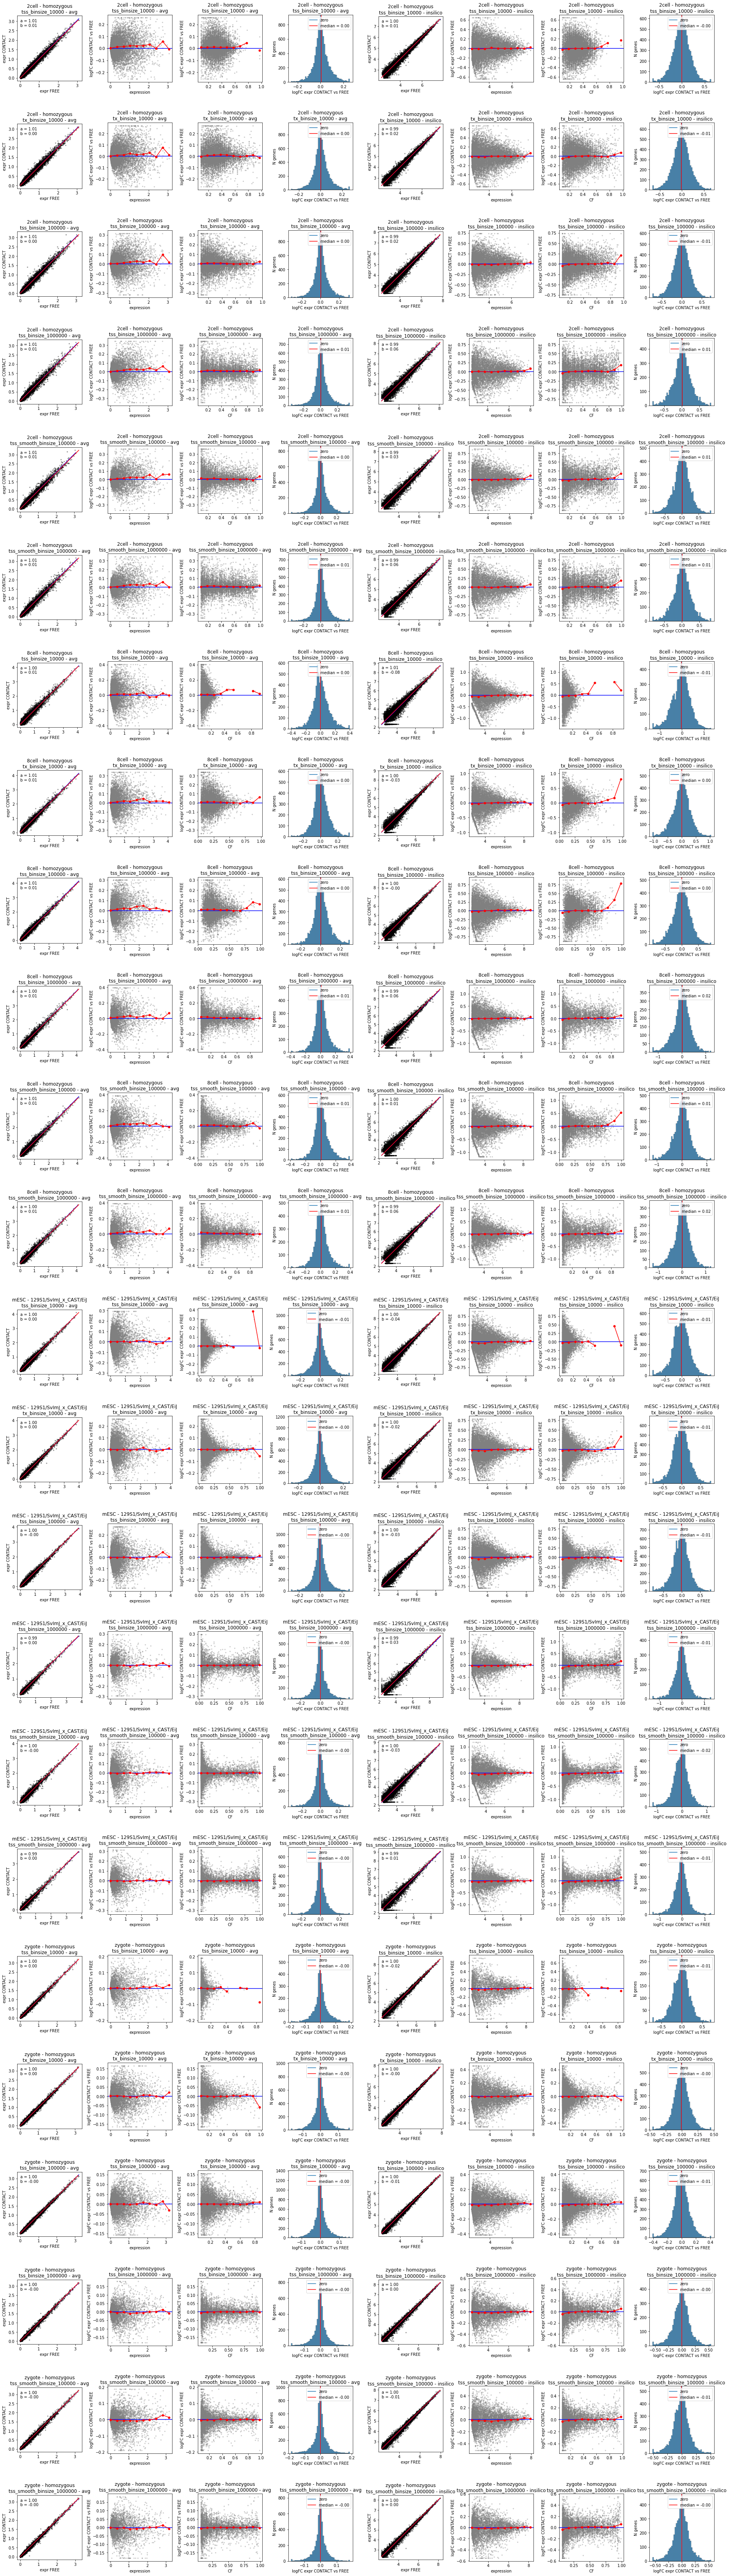

In [26]:
nrow = len(expr_logfc_contact.keys()) * 6
ncol = 8

fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 5*nrow))
plt.subplots_adjust(hspace=.6, wspace=.4)
irow = -1

for condition in expr_logfc_contact.keys():
    
    for damidset in expr_logfc_contact[condition].keys():
        
        irow += 1
        
        for icol, method in enumerate(['avg', 'insilico']):
            ax0 = axes[irow, icol*4]
            ax1 = axes[irow, icol*4+1]
            ax2 = axes[irow, icol*4+2]
            ax3 = axes[irow, icol*4+3]
            
            ax0.set_title('%s - %s\n%s - %s' % (condition[0], condition[1], damidset, method))
            ax1.set_title('%s - %s\n%s - %s' % (condition[0], condition[1], damidset, method))
            ax2.set_title('%s - %s\n%s - %s' % (condition[0], condition[1], damidset, method))
            ax3.set_title('%s - %s\n%s - %s' % (condition[0], condition[1], damidset, method))
            
            df = expr_logfc_contact[condition][damidset][method].copy()
            ind0 = ~genes.loc[df.index, 'is_maternal'].values
#             ind1 = df['expr'] > 0.2
            df = df[ind0]
            
            X = df['expr_free'].values
            Y = df['expr_contact'].values
            Z = df['expr'].values
            A = df['CF'].values
            ind = ~(np.isnan(X) | np.isnan(Y))
            X = X[ind]
            Y = Y[ind]
            Z = Z[ind]
            A = A[ind]
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
            
            ## plot expr in free vs contact states
            ax0.scatter(X, Y, s=5, c='k', alpha=.3)
            ax0.set_aspect('equal')
            
            x = [X.min(), X.max()]
            y = [(slope*X.min())+intercept, (slope*X.max())+intercept]
            ax0.plot(x, y, c='b')
            ax0.text(0.05, 0.95, 'a = %.2f\nb = %.2f' % (slope, intercept), transform=ax0.transAxes, va='top', ha='left')
            
            ax0.plot([Y.min(), Y.max()], [Y.min(), Y.max()], c='r')
            ax0.set_xlabel('expr FREE')
            ax0.set_ylabel('expr CONTACT')
            
            ## plot logFC vs avg expr
            delta = (Y-X)
            mx = np.percentile(abs(delta), 99.5)
            ax1.scatter(Z, delta.clip(-mx,mx), s=5, c='grey', alpha=.3)
            ax1.set_xlabel('expression')
            ax1.set_ylabel('logFC expr CONTACT vs FREE')
            ax1.axhline(0, c='b')
            
            x, m, s = compute_trendline(Z, Y-X, nsteps=10)
            ax1.plot(x, m, 'o-', c='r', ms=5)
#             ax1.fill_between(x, m-s, m+s, color='r', alpha=.2)
            
            ## plot logFC vs CF
            ax2.scatter(A, delta.clip(-mx,mx), s=5, c='grey', alpha=.3)
            ax2.set_xlabel('CF')
            ax2.set_ylabel('logFC expr CONTACT vs FREE')
            ax2.axhline(0, c='b')
            
            x, m, s = compute_trendline(A, Y-X, nsteps=10)
            ax2.plot(x, m, 'o-', c='r', ms=5)
#             ax2.fill_between(x, m-s, m+s, color='r', alpha=.2)

            ## plot logFC distribution
            sns.histplot(delta.clip(-mx,mx), bins=50, ax=ax3)
            ax3.set_xlabel('logFC expr CONTACT vs FREE')
            ax3.set_ylabel('N genes')
            m = np.median(Y-X)
            ax3.axvline(0, label='zero')
            ax3.axvline(m, label='median = %.2f' % m, c='r')
            ax3.legend()

## 2.3 In silico logFC expression between contact/free states

- Based on smoothened binarized data at TSS, 100kb

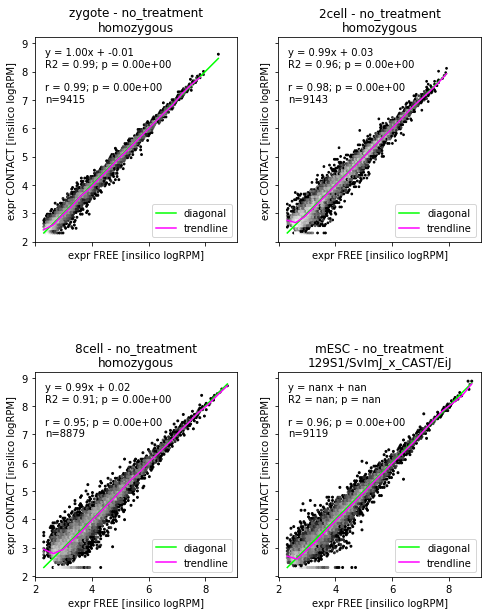

In [26]:
region = 'tss_smooth_binsize_100000'
metric = 'insilico'


nplot = len(expr_logfc_contact.keys())
ncol = 2
nrow = int(np.ceil(nplot/ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=.6)
counter = 0

tmp = {stage: i for i, stage in enumerate(stage_order)}
sorted_keys = sorted(expr_logfc_contact.keys(), key = lambda k: (tmp[k[0]], k[1], k[2]))

for condition in sorted_keys:

    ax = axes.flatten()[counter]
    counter += 1

    to_plot = expr_logfc_contact[condition][region][metric].copy()

    # remove maternal mRNA genes
#     ind0 = ~genes.loc[to_plot.index, 'is_maternal'].values
#     to_plot = to_plot[ind0]

    ax.set_title('%s - %s\n%s' % (condition[0], condition[2], condition[1]))

    Y = to_plot['expr_contact']
    X = to_plot['expr_free']
    nanind = np.isnan(X) | np.isnan(Y)

#     ax.scatter(X, Y, c='k', s=5)
    ax.hexbin(X, Y, bins='log', mincnt=1, cmap='Greys_r')
    ax.set_aspect('equal')
    ax.plot([X.min(), X.max()], [X.min(), X.max()], c='lime', label='diagonal')
    x, m, s = compute_trendline(X, Y, nsteps=20)
    ax.plot(x, m, '-', c='magenta', ms=5, label='trendline')
    ax.legend(loc='lower right')

    ax.set_xlabel('expr FREE [insilico logRPM]')
    ax.set_ylabel('expr CONTACT [insilico logRPM]')


    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
    r = stats.linregress(X[~nanind], Y[~nanind])
    t0 = 'y = %.2fx + %.2f\nR2 = %.2f; p = %.2e' % (np.round(slope,2), np.round(intercept,2), np.round(r_value**2,2), p_value)

    r,p = stats.pearsonr(X[~nanind], Y[~nanind])
    t1 = ('r = %.2f; p = %.2e\nn=%d' % (r, p, len(X[~nanind])))

    t = t0 + '\n\n' + t1

    ax.text(0.05, 0.95, t, va='top', ha='left', transform=ax.transAxes)
    
while counter < (nrow*ncol):
    axes.flatten()[counter].remove()
    counter += 1

outfn = FIGOUTDIR + 'gene_expression_with_vs_without_NL_contact.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 2.4 In silico logFC expression between contact/free states - divided by gene category

- Based on smoothened binarized data at TSS, 100kb

In [27]:
to_plot = expr_logfc_contact[condition][region][metric].copy()
to_plot

expr  expr_contact  expr_free        CF  n_cells_expr  \
gene_id                                                                         
ENSMUSG00000025902  2.655984      2.677547   2.599248  0.719388            13   
ENSMUSG00000103922  2.584810      2.625189   2.540273  0.489796             9   
ENSMUSG00000102275  3.269714      3.093588   3.427328  0.489796            47   
ENSMUSG00000033845  6.095842      6.059486   6.132889  0.489796           183   
ENSMUSG00000025903  4.972196      4.951060   4.987356  0.428571           151   
...                      ...           ...        ...       ...           ...   
ENSMUSG00000025742  4.640382      4.638702   5.347679  0.994898           123   
ENSMUSG00000031358  3.408396      3.408396        NaN  1.000000            47   
ENSMUSG00000031352  5.971674      5.974025   5.127405  0.994898           185   
ENSMUSG00000081137  2.916580      2.918473   2.302585  0.994898            24   
ENSMUSG00000035299  2.508178      2.508623   2.302585  0.994898             6   

                    frac_cells_expr  
gene_id                              
ENSMUSG00000025902         0.066327  
ENSMUSG00000103922         0.045918  
ENSMUSG00000102275         0.239796  
ENSMUSG00000033845         0.933673  
ENSMUSG00000025903         0.770408  
...                             ...  
ENSMUSG00000025742         0.627551  
ENSMUSG00000031358         0.239796  
ENSMUSG00000031352         0.943878  
ENSMUSG00000081137         0.122449  
ENSMUSG00000035299         0.030612  

[9122 rows x 6 columns]

In [29]:
genes.groupby(['Park_cluster']).size()

Park_cluster
1-Cell_Transient      517
2-Cell_Transient     1618
4-Cell_Transient     1508
MGA                  1953
Major_ZGA            1594
Maternal_RNA         4231
Maternal_to_MGA      1215
Maternal_to_ZGA       390
Minor_ZGA            3420
Minor_ZGA_to_MGA      685
no_cluster          34159
dtype: int64

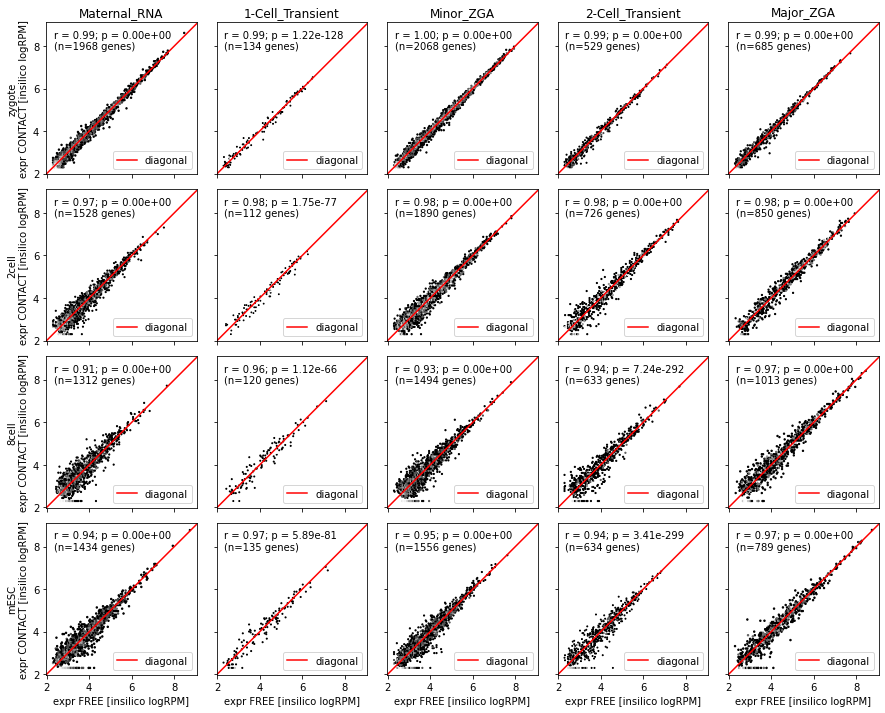

In [42]:
region = 'tss_smooth_binsize_100000'
metric = 'insilico'
gene_cats = ['Maternal_RNA', '1-Cell_Transient', 'Minor_ZGA', '2-Cell_Transient', 'Major_ZGA']


nrow = len(expr_logfc_contact.keys())
ncol = len(gene_cats)

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*3), sharex=True, sharey=True)
plt.subplots_adjust(hspace=.1, wspace=.1)
counter = 0

tmp = {stage: i for i, stage in enumerate(stage_order)}
sorted_keys = sorted(expr_logfc_contact.keys(), key = lambda k: (tmp[k[0]], k[1], k[2]))

for irow, condition in enumerate(sorted_keys):

    

    for icol, cat in enumerate(gene_cats):

        # select relevant genes
        to_plot = expr_logfc_contact[condition][region][metric].copy()
        ind = genes.loc[to_plot.index, 'Park_cluster'] == cat
        to_plot = to_plot[ind]

        ax = axes[irow, icol]
        
        
        Y = to_plot['expr_contact']
        X = to_plot['expr_free']
        nanind = np.isnan(X) | np.isnan(Y)

    #     ax.scatter(X, Y, c='k', s=5)
        ax.hexbin(X, Y, bins='log', mincnt=1, cmap='Greys_r')
        ax.set_aspect('equal')

        if irow == (nrow-1):
            ax.set_xlabel('expr FREE [insilico logRPM]')
        if icol == 0:
            cond_txt = '%s - %s (%s)' % (condition[0], condition[2], condition[1])
            ax.set_ylabel('%s\nexpr CONTACT [insilico logRPM]' % condition[0])
        if irow == 0:
            ax.set_title(cat)

        r,p = stats.pearsonr(X[~nanind], Y[~nanind])
        t1 = ('r = %.2f; p = %.2e\n(n=%d genes)' % (r, p, len(to_plot)))
        ax.text(0.05, 0.95, t1, va='top', ha='left', transform=ax.transAxes)
        
for ax in axes.flatten():
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, xlim, c='r', label='diagonal')
    ax.legend(loc='lower right')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

outfn = FIGOUTDIR + 'gene_expression_with_vs_without_NL_contact.split_by_Park_gene_clusters.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 2.5 In silico logFC expression between contact/free states - divided by CF

- Based on smoothened binarized data at TSS, 100kb

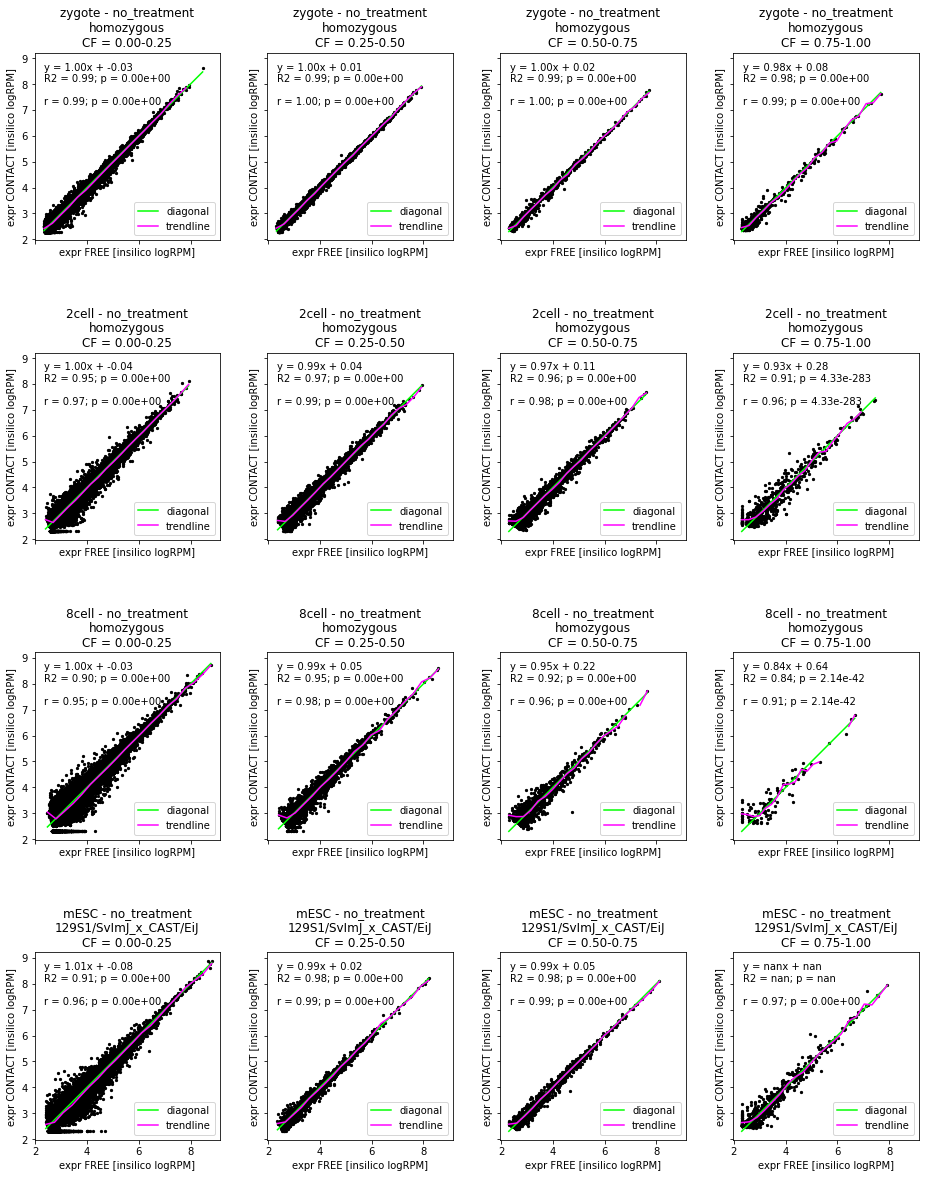

In [28]:
region = 'tss_smooth_binsize_100000'
metric = 'insilico'
catsize = .25

ncol = int(1 / catsize)
nrow = len(expr_logfc_contact.keys())
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=.6)
r_counter = 0

tmp = {stage: i for i, stage in enumerate(stage_order)}
sorted_keys = sorted(expr_logfc_contact.keys(), key = lambda k: (tmp[k[0]], k[1], k[2]))

for condition in sorted_keys:

    c_counter = 0

    to_plot = expr_logfc_contact[condition][region][metric].copy()
    to_plot['CF_cat'] = (to_plot['CF'] // catsize).astype(int).clip(0, (1/catsize)-1)
    
    # remove maternal mRNA genes
#     ind0 = ~genes.loc[to_plot.index, 'is_maternal'].values
#     to_plot = to_plot[ind0]

    for cat, df in to_plot.groupby('CF_cat'):

        ax = axes[r_counter, c_counter]
        c_counter += 1

        ax.set_title('%s - %s\n%s\nCF = %.2f-%.2f' % (condition[0], condition[2], condition[1], cat*catsize, (cat+1)*catsize))

        Y = df['expr_contact']
        X = df['expr_free']
        nanind = np.isnan(X) | np.isnan(Y)

        ax.scatter(X, Y, c='k', s=5)
#         ax.hexbin(X, Y, bins='log', mincnt=1, cmap='Greys_r')
        ax.set_aspect('equal')
        ax.plot([X.min(), X.max()], [X.min(), X.max()], c='lime', label='diagonal')
        x, m, s = compute_trendline(X, Y, nsteps=20)
        ax.plot(x, m, '-', c='magenta', ms=5, label='trendline')
        ax.legend(loc='lower right')

        ax.set_xlabel('expr FREE [insilico logRPM]')
        ax.set_ylabel('expr CONTACT [insilico logRPM]')


        slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
        r = stats.linregress(X[~nanind], Y[~nanind])
        t0 = 'y = %.2fx + %.2f\nR2 = %.2f; p = %.2e' % (np.round(slope,2), np.round(intercept,2), np.round(r_value**2,2), p_value)

        r,p = stats.pearsonr(X[~nanind], Y[~nanind])
        t1 = ('r = %.2f; p = %.2e' % (r, p))

        t = t0 + '\n\n' + t1

        ax.text(0.05, 0.95, t, va='top', ha='left', transform=ax.transAxes)

        
    r_counter += 1

outfn = FIGOUTDIR + 'gene_expression_with_vs_without_NL_contact.split_in_CF_categories.pdf'
plt.savefig(outfn, bbox_inches='tight')